In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [5]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [6]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

qrels = qrels[['RTS212', 'RTS48']]

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [7]:
point = pd.read_csv(
    'eval/RTS17/gundog/ngram-length(3)_keep-spam(0)_language(en)_extract-retweets(1)_keep-retweets(0).point',
    sep=' ',
    names=[
        'topic', 'tweet_id',
        'Distance to query',
        'Distance to positive', 'Distance to negative',
        'Score',
        'retrieve', 'Positive', 'Negative',
    ],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
#     dtype={'Negative': int},
).unstack('topic')

# point = pd.concat([point], axis=1, keys=['Point'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

point.columns.names = 'Variable', 'Topic'

/diskp/dnm11/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
point.size

3008352

In [9]:
topics = list(point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all').columns.values)

In [10]:
# (
#     point['Distance to query'][topics]
#     .apply(np.vectorize(lambda v: v if v < 0.9 else None)).dropna(how='all')
#     .plot(style='o', use_index=False, figsize=(14, 6))
# );

In [11]:
point.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:10]

Variable           Distance to query           Distance to positive            \
Topic                         RTS212     RTS48               RTS212     RTS48   
tweet_id                                                                        
891215331473096704          0.946797  0.969328             0.478271  0.969328   
891208243359490051          0.867146  1.000000             0.503911  1.000000   
891259744958033922          0.899579  1.000000             0.478812  1.000000   
891235790344335360          0.873471  0.986585             0.646754  0.986585   
890960124243783681          0.878503  0.981605             0.790102  0.981605   
890015143056220161          0.734364  1.000000             0.734364  1.000000   
891212986857254912          0.877858  1.000000             0.865857  1.000000   
891176583968550913          0.890592  1.000000             0.803958  1.000000   
891153319477075968          0.748445  1.000000             0.748445  1.000000   
891207215494946816          0.887706  1.000000             0.844327  1.000000   

Variable           Distance to negative               Score            \
Topic                            RTS212     RTS48    RTS212     RTS48   
tweet_id                                                                
891215331473096704             0.961149  0.949459  0.497603  1.020926   
891208243359490051             0.940283  0.948409  0.535915  1.054398   
891259744958033922             0.855451  0.959356  0.559719  1.042366   
891235790344335360             0.914942  0.929168  0.706880  1.061793   
890960124243783681             0.937993  0.981446  0.842333  1.000162   
890015143056220161             0.857840  0.942013  0.856062  1.061556   
891212986857254912             0.991415  0.965207  0.873355  1.036048   
891176583968550913             0.913052  0.950135  0.880518  1.052482   
891153319477075968             0.850000  0.850000  0.880523  1.176471   
891207215494946816             0.958673  0.957534  0.880725  1.044350   

Variable           retrieve        Positive       Negative       Relevance  \
Topic                RTS212  RTS48   RTS212 RTS48   RTS212 RTS48    RTS212   
tweet_id                                                                     
891215331473096704     True  False      4.0   1.0      3.0   2.0       1.0   
891208243359490051     True  False      5.0   1.0      4.0   2.0       1.0   
891259744958033922     True  False      9.0   1.0      8.0   3.0       1.0   
891235790344335360     True  False      6.0   1.0      5.0   2.0       1.0   
890960124243783681     True  False      8.0   1.0      5.0   3.0       1.0   
890015143056220161     True  False     10.0   1.0      9.0   4.0       NaN   
891212986857254912     True  False      3.0   1.0      3.0   2.0       NaN   
891176583968550913     True  False     18.0   1.0     12.0   4.0       1.0   
891153319477075968     True  False      1.0   1.0      0.0   0.0       NaN   
891207215494946816     True  False      3.0   1.0      3.0   2.0       1.0   

Variable                  
Topic              RTS48  
tweet_id                  
891215331473096704   NaN  
891208243359490051   NaN  
891259744958033922   NaN  
891235790344335360   NaN  
890960124243783681   NaN  
890015143056220161   NaN  
891212986857254912   NaN  
891176583968550913   NaN  
891153319477075968   NaN  
891207215494946816   NaN

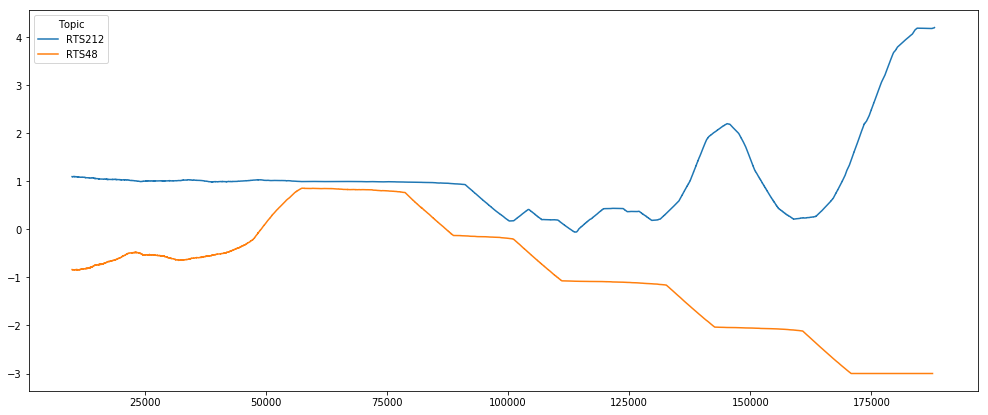

In [12]:
(
    point['Positive']
#     point['retrieve'].cumsum()
    - point['Negative'])[topics].rolling(10_000).mean().plot(use_index=False, figsize=(17, 7)
);

In [13]:
point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all')

Topic,RTS212,RTS48
0.0,29,12.0
1.0,26,NaN


In [14]:
distance_score = (
    point[['Distance to query', 'Score', 'Relevance']]
    .stack('Topic')
    .dropna(subset=['Relevance'])
    .set_index('Relevance', append=True)
    .stack().to_frame('Value')
    .reset_index()
    .set_index(['Topic', 'tweet_id'])
)

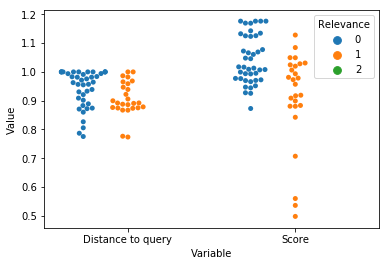

In [15]:
sns.swarmplot(
    data=distance_score, x='Variable', y='Value', hue='Relevance', hue_order=[0, 1, 2], dodge=True
);

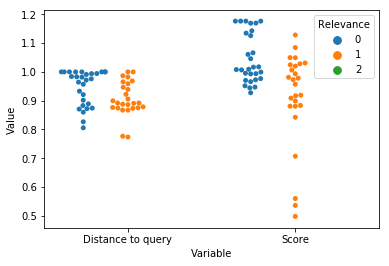

In [16]:
sns.swarmplot(
    data=distance_score.loc['RTS212'], x='Variable', y='Value', hue='Relevance', hue_order=[0, 1, 2], dodge=True
);

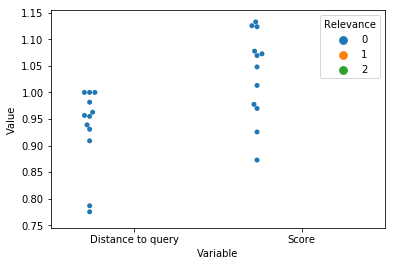

In [17]:
sns.swarmplot(
    data=distance_score.loc['RTS48'], x='Variable', y='Value', hue='Relevance', hue_order=[0, 1, 2], dodge=True
);

In [18]:
# point[['Distance to query', 'Score']].cummin().plot(use_index=False);

In [19]:
# point[['Distance to query', 'Score']].rolling(1_000_000, min_periods=1).min().plot(use_index=False);

In [20]:
point['Distance to query'].corrwith(point['Score'])

Topic
RTS212    0.151787
RTS48     0.276929
dtype: float64